**1. Import required libraries**

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import os

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

**2. Load the data**

In [2]:
# datalink = "https://www.kaggle.com/datasets/tejashvi14/tour-travels-customer-churn-prediction"
dataset = pd.read_csv("/content/Customertravel.csv")

In [3]:
print(dataset.shape)
dataset.head(2)

(954, 7)


,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1


**3. EDA**

In [4]:
dataset.describe()

,Age,ServicesOpted,Target
count,954.000000,954.000000,954.000000
mean,32.109015,2.437107,0.234801
std,3.337388,1.606233,0.424097
min,27.000000,1.000000,0.000000
25%,30.000000,1.000000,0.000000
50%,31.000000,2.000000,0.000000
75%,35.000000,4.000000,0.000000
max,38.000000,6.000000,1.000000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    object
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Target                      954 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 52.3+ KB


In [6]:
# printing unique values in each column
for col in dataset.columns:
  print(col,":-", dataset[col].unique())
  print("_"*80)

Age :- [34 37 30 27 36 28 35 31 38 33 29]
________________________________________________________________________________
FrequentFlyer :- ['No' 'Yes' 'No Record']
________________________________________________________________________________
AnnualIncomeClass :- ['Middle Income' 'Low Income' 'High Income']
________________________________________________________________________________
ServicesOpted :- [6 5 3 2 1 4]
________________________________________________________________________________
AccountSyncedToSocialMedia :- ['No' 'Yes']
________________________________________________________________________________
BookedHotelOrNot :- ['Yes' 'No']
________________________________________________________________________________
Target :- [0 1]
________________________________________________________________________________


In [7]:
dataset['Target'].value_counts()

,count
Target,
0,730
1,224


**Insights**
1. No null values found in the data
2. Found 3 numeric columns including the target column
3. Found 4 categorical columns
4. Class imbalance identified in target

**Numerical Features Analysis**

In [8]:
def plot_histogram(df, col):
  plt.figure(figsize=(4,4))
  sns.histplot(df[col], kde=True)
  plt.title('Distribution of {}'.format(col))
  col_mean = df[col].mean()
  col_median = df[col].median()
  plt.axvline(col_mean, color ='black', label = 'Mean')
  plt.axvline(col_median, color ='red', label = 'Median')
  plt.legend()
  plt.show()

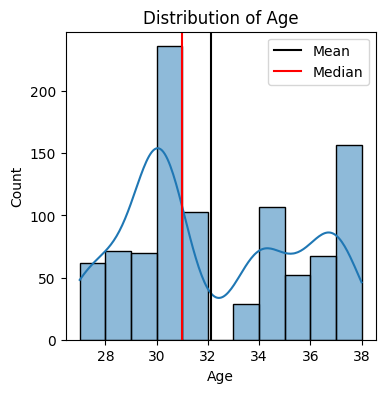

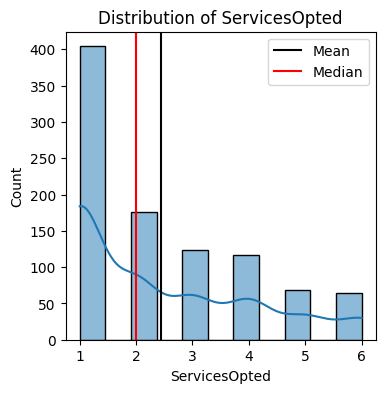

In [9]:
for col in ['Age', 'ServicesOpted']:
  plot_histogram(dataset, col)

Distributions of both the colums is non uniform and ServicesOpted feature is little skewed

In [10]:
def plot_boxplot(df, col):
  plt.figure(figsize = (4,4))
  sns.boxplot(y = df[col])
  plt.title("Distribution of {}".format(col))
  plt.ylabel(col)
  plt.show()

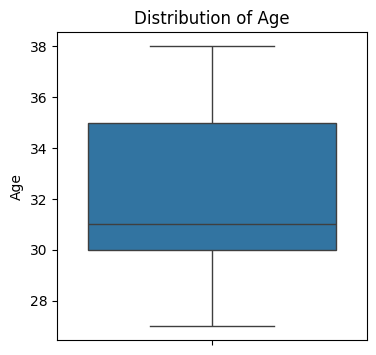

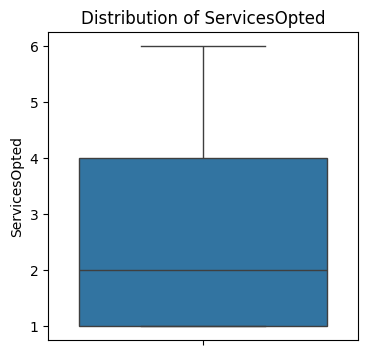

In [11]:
for col in ['Age', 'ServicesOpted']:
  plot_boxplot(dataset, col)

No outliers present in any of the numeric column

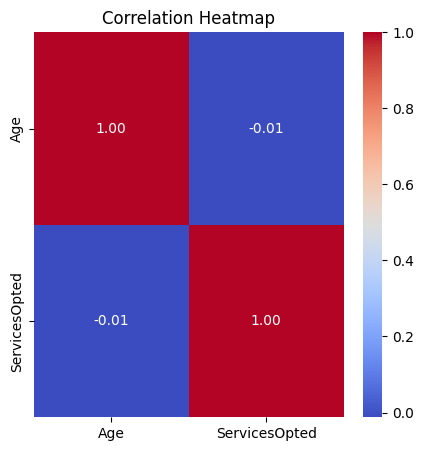

In [12]:
plt.figure(figsize = (5,5))
sns.heatmap(dataset[['Age', 'ServicesOpted']].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Heatmap')
plt.show()

The two columns are not correlated to each other, so it will not affect the model

**Categorical Features Analysis**

In [13]:
cat_col = dataset.select_dtypes(include = 'object').columns.to_list()
cat_col

['FrequentFlyer',
 'AnnualIncomeClass',
 'AccountSyncedToSocialMedia',
 'BookedHotelOrNot']

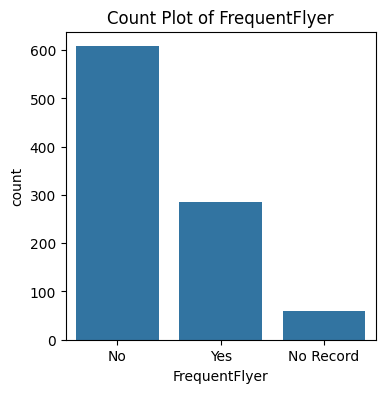

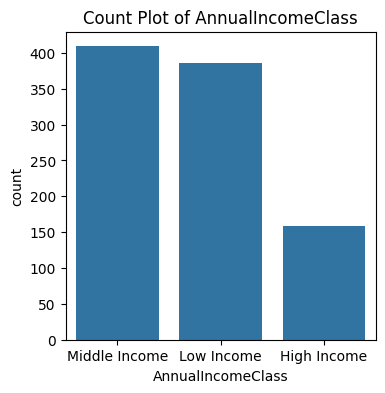

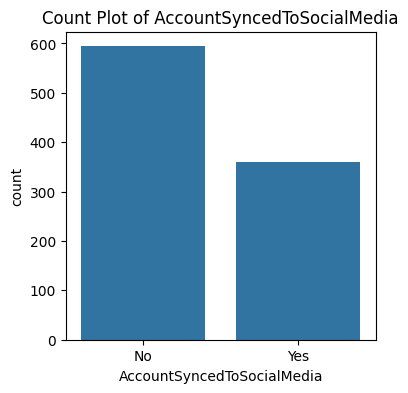

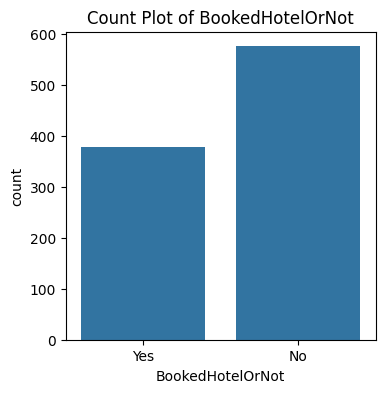

In [14]:
for col in cat_col:
  plt.figure(figsize = (4,4))
  sns.countplot(x = dataset[col]),
  plt.title("Count Plot of {}".format(col))
  plt.show()

**4. Data Preprocessing**

Label Encoding of categorical features

In [15]:
#initializing dictionary to save the encoders
encoders = {}

#apply lable encoding and save the encoders

for col in cat_col:
  label_encoder = LabelEncoder()
  dataset[col] = label_encoder.fit_transform(dataset[col])
  encoders[col] = label_encoder

with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)

In [16]:
dataset.head(2)

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,0,2,6,0,1,0
1,34,2,1,5,1,0,1


**Test Train Split**

In [17]:
x = dataset.drop(columns = ['Target'])
y = dataset['Target']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

In [19]:
y_train.value_counts()

,count
Target,
0,577
1,186


handelling class imbalance using SMOTE (Synthetic Minority Oversample Technique)

In [20]:
smote = SMOTE(random_state = 42)

In [21]:
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [22]:
y_train_smote.value_counts()

,count
Target,
0,577
1,577


Now we have evqual values for both the classes

**5. Model Training**

In [23]:
models = {
      "Decision Tree": DecisionTreeClassifier(random_state = 42),
      "Random Forest": RandomForestClassifier(random_state = 42),
      "XGBoost": XGBClassifier(random_state = 42)
}

In [24]:
#dictionary to store cross validation results
cv_scores = {}

for model_name, model in models.items():
  scores = cross_val_score(model, x_train_smote, y_train_smote, cv = 5, scoring = 'accuracy')
  cv_scores[model_name] = scores
  print("{} cross validation accuracy: {} ".format(model_name, np.mean(scores)))

Decision Tree cross validation accuracy: 0.9142292490118576 
Random Forest cross validation accuracy: 0.9220214568040654 
XGBoost cross validation accuracy: 0.9254808959156786 


In [25]:
cv_scores

{'Decision Tree': array([0.8961039 , 0.90909091, 0.9047619 , 0.92640693, 0.93478261]),
 'Random Forest': array([0.91341991, 0.91774892, 0.91774892, 0.92640693, 0.93478261]),
 'XGBoost': array([0.92207792, 0.92640693, 0.91774892, 0.93073593, 0.93043478])}

XGBoost gives the highest accuracy comapred to other models with default parameters

In [26]:
xgb = XGBClassifier(random_state = 42)

In [27]:
xgb.fit(x_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [28]:
y_test.value_counts()

,count
Target,
0,153
1,38


**6. Model Evaluation**

In [29]:
#evaluation on test data

y_test_pred = xgb.predict(x_test)

print("Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("_"*60)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("_"*60)
print("Classification Report:\n", classification_report(y_test, y_test_pred))


Accuracy Score: 0.8900523560209425
____________________________________________________________
Confusion Matrix:
 [[137  16]
 [  5  33]]
____________________________________________________________
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       153
           1       0.67      0.87      0.76        38

    accuracy                           0.89       191
   macro avg       0.82      0.88      0.84       191
weighted avg       0.91      0.89      0.89       191



In [30]:
#save the trained model in a pickel file
model_data = {"model": xgb, "feature_list" : x.columns.to_list()}

with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(model_data, f)

**7. Load the saved model and build a predictive system**

In [31]:
with open(f"customer_churn_model.pkl", 'rb') as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["feature_list"]

In [32]:
feature_names

['Age',
 'FrequentFlyer',
 'AnnualIncomeClass',
 'ServicesOpted',
 'AccountSyncedToSocialMedia',
 'BookedHotelOrNot']

In [33]:
# testing the model with an example where target initially is 0(No Churn)
input_data = {"Age": 34,
              "FrequentFlyer": "No",
              "AnnualIncomeClass": "Middle Income",
              "ServicesOpted": 6,
              "AccountSyncedToSocialMedia": "No",
              "BookedHotelOrNot": "Yes"}

df = pd.DataFrame([input_data])

with open("encoders.pkl", "rb") as f:
  encoders = pickle.load(f)

for column, encoder in encoders.items():
  df[column] = encoder.transform(df[column])

In [38]:
prediction = loaded_model.predict(df)
prediction_probability = loaded_model.predict_proba(df)

print("Prediction:", "Churn" if prediction[0] == 1 else "No Churn")
print("Prediction probability:", prediction_probability)

Prediction: No Churn
Prediction probability: [[0.9971962  0.00280378]]
